In [2]:
import cometToolkit as ctk
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

from mpl_toolkits.axes_grid1 import ImageGrid

from statsmodels.stats.weightstats import DescrStatsW
from astropy.stats import sigma_clipped_stats


from natsort import natsorted
from glob import glob

mpl.rcParams.update({'font.size': 14})

In [3]:
# We want to show all stacked images in one figure for appendix

V = ctk.GetImage(f"../../Python/DataProducts/StackedImages/Day12/vStacked.fits")
R = ctk.GetImage(f"../../Python/DataProducts/StackedImages/Day12/rStacked.fits")
B = ctk.GetImage(f"../../Python/DataProducts/StackedImages/Day12/bStacked.fits")

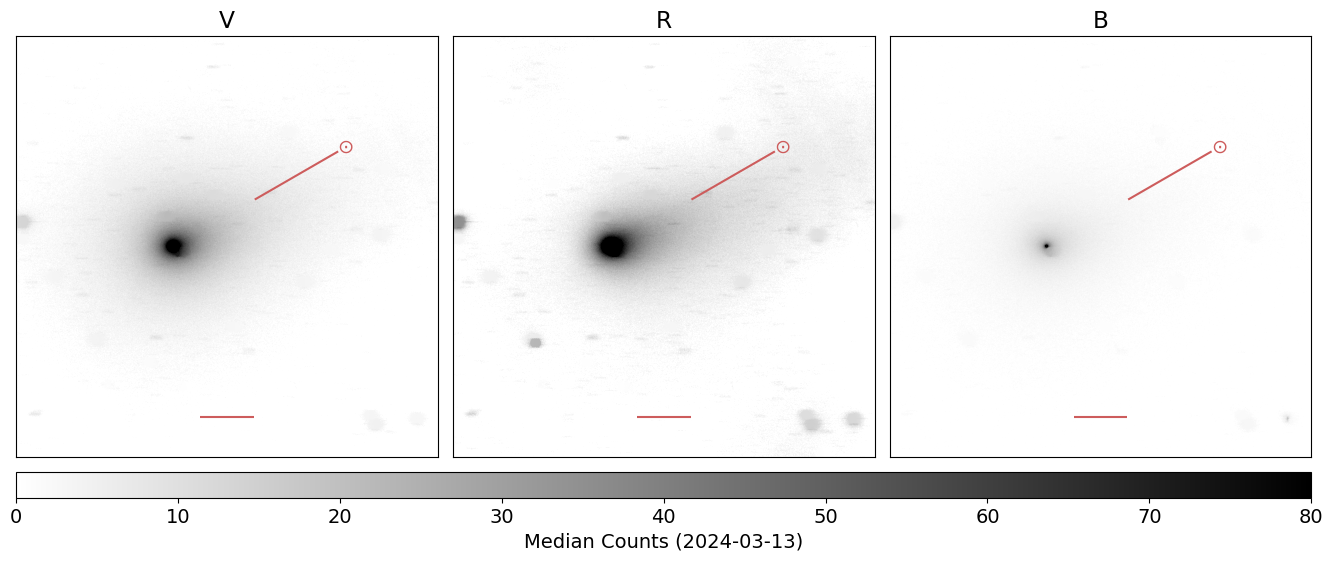

In [4]:
fig = plt.figure(figsize=(18, 6))

titles = ["V", "R", "B"]
images = [V, R, B]
limits = [(0, 80)]*3

grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,3),
                 axes_pad=0.15,
                 share_all=True,
                 cbar_location="bottom",
                 cbar_mode="single",
                 cbar_size="2%",
                 cbar_pad=0,
                 )

for i, ax in enumerate(grid):
    im = ax.imshow(images[i], vmin=limits[i][0], vmax=limits[i][1], cmap="binary")

    ax.set_xticks([])
    ax.set_yticks([])

    ax.set_title(titles[i])
    ax.set_aspect("equal")

ax.cax.colorbar(im, label="Median Counts (2024-03-13)")


# Adding sun vector
pa = 300 # degrees

def SunVector(x, pa):
    y = -(x) * np.tan((pa+90) * np.pi / 180)
    return y

for ax in grid:
    length = 300
    spacing = 300
    xOffset = 580
    yOffset = 773
    lineRange = np.linspace(0, length, 100)
    ax.plot((lineRange + xOffset + spacing), (SunVector(lineRange, pa) + yOffset + SunVector(spacing, pa)),
            color="indianred")

    ax.text(xOffset + spacing + length, SunVector(spacing + length, pa) + yOffset, r"$\odot$", color="indianred")

# Adding scale bar
for ax in grid:
    sizeKm = 50000 # km
    cometDistance = 0.585 * 1.496e8 # au to km

    sizePx = (180 * 3600) / (0.6 * np.pi) * np.arctan2(sizeKm, cometDistance)

    centre = (len(images[0]) / 2)

    ax.hlines([1400], xmin=centre - sizePx/2, xmax=centre + sizePx/2, color="indianred")


plt.savefig("../../Writing/Thesis/images/stacked_comets.pdf", format="pdf", bbox_inches="tight")

## Repeating for all days

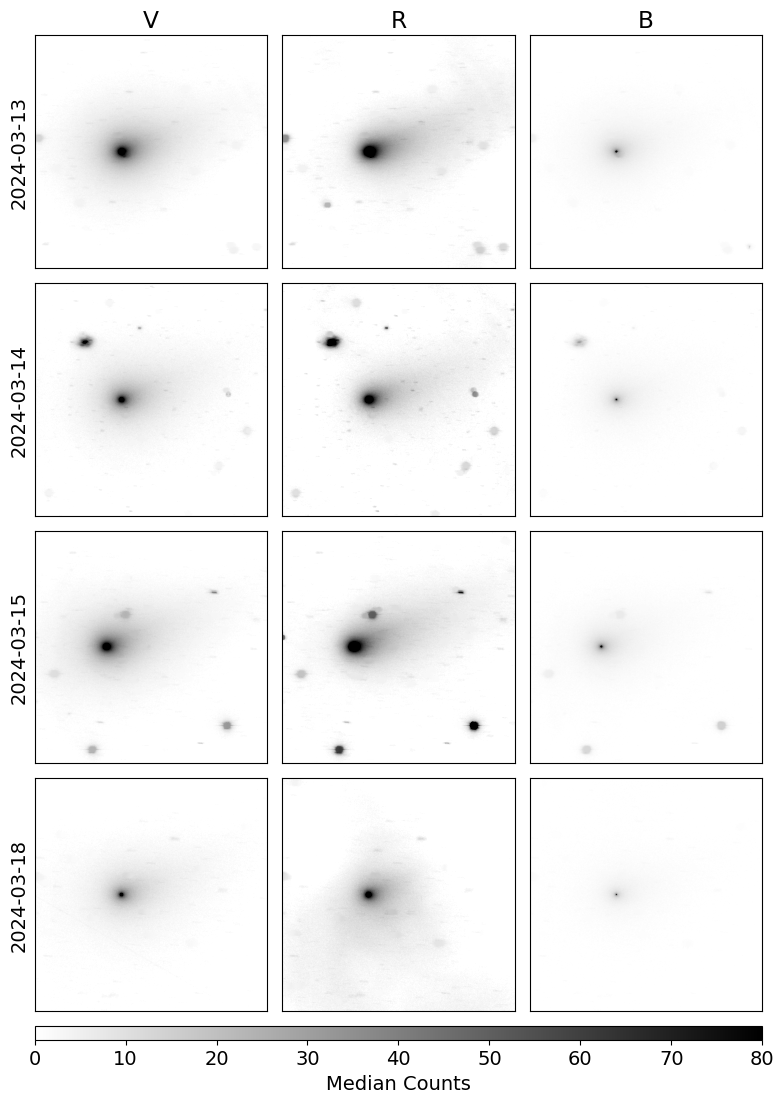

In [30]:
days = ["Day12", "Day13", "Day14", "Day17"]

vImages = []
rImages = []
bImages = []

for day in days:

    vImages.append(ctk.GetImage(f"../../Python/DataProducts/StackedImages/{day}/vStacked.fits"))
    rImages.append(ctk.GetImage(f"../../Python/DataProducts/StackedImages/{day}/rStacked.fits"))
    bImages.append(ctk.GetImage(f"../../Python/DataProducts/StackedImages/{day}/bStacked.fits"))

images = [vImages[0], rImages[0], bImages[0],
          vImages[1], rImages[1], bImages[1],
          vImages[2], rImages[2], bImages[2],
          vImages[3], rImages[3], bImages[3]]

fig = plt.figure(figsize=(50, 60))

titles = ["V", "R", "B"]
dayLabels = ["2024-03-13", "2024-03-14", "2024-03-15", "2024-03-18"]

limits = [(0, 80)]*12

grid = ImageGrid(fig, 431,          # as in plt.subplot(111)
                 nrows_ncols=(4,3),
                 axes_pad=0.15,
                 share_all=True,
                 cbar_location="bottom",
                 cbar_mode="single",
                 cbar_size="2%",
                 cbar_pad=0,
                 )

labelIndex = 0
for i, ax in enumerate(grid):
    im = ax.imshow(images[i], vmin=limits[i][0], vmax=limits[i][1], cmap="binary")

    ax.set_xticks([])
    ax.set_yticks([])

    ax.set_aspect("equal")

    if i < 3: ax.set_title(titles[i])

    if i % 3 == 0:
        ax.set_ylabel(dayLabels[labelIndex])
        labelIndex += 1

ax.cax.colorbar(im, label="Median Counts")

plt.savefig("../../Writing/Thesis/images/all_stacked_comets.pdf", format="pdf", bbox_inches="tight")

# Context Plot

In [4]:
shortPeriods = np.loadtxt("../../Data/Archive/shortPeriods.txt", delimiter=",")
longPeriods = np.loadtxt("../../Data/Archive/longPeriods.txt", delimiter=",")

In [5]:
# Get our data, weighted average of the R data
activityDataPaths = natsorted(glob("../DataProducts/Activity/Evolution/*"))

activities = []
errors = []

for path in activityDataPaths:
    data = np.loadtxt(path)

    activities.append(data[:,1][1])
    errors.append(data[:,2][1])

activityStats = DescrStatsW(activities, weights=errors)
activityMean = activityStats.mean
activityError = activityStats.std

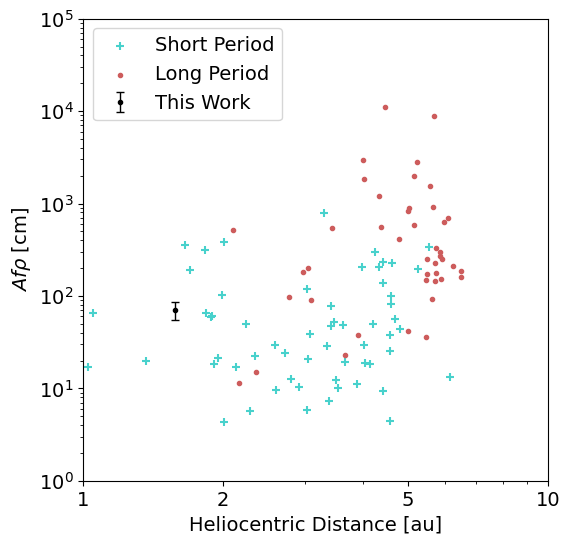

In [6]:
fig, ax = plt.subplots(figsize=(6,6))

ax.scatter(shortPeriods[:,0], shortPeriods[:,1], color="mediumturquoise", marker="+", s=30, label="Short Period")
ax.scatter(longPeriods[:,0], longPeriods[:,1], color="indianred", marker=".", label="Long Period")

ax.errorbar(1.58, activityMean, yerr=activityError, fmt=".", color="black", capsize=3, lw=1, label="This Work")

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlim(1, 10)
ax.set_ylim(1, 100000)

ax.set_xticks([1, 2, 5, 10])
ax.set_xticks([3, 4, 6, 7, 8, 9], minor=True)
ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax.xaxis.set_minor_formatter("")

ax.set_xlabel("Heliocentric Distance [au]")
ax.set_ylabel(r"$Af\rho$ [cm]")

ax.legend()

plt.savefig("../../Writing/Thesis/images/context_plot.pdf", format="pdf", bbox_inches="tight")

# Coma and Tail Extent
Want to plot everything above 1 sigma threshold from background

In [3]:
# Chosing the day with the best seeing
imagePath = natsorted(glob(f"../../Python/DataProducts/ReducedImages/Day13/R/*"))[:-2][0]

image = ctk.GetImage(imagePath)

In [4]:
mean, median, std = sigma_clipped_stats(image, sigma=5)
background = median
print(mean, median, std)

286.17693891980116 285.75429150229235 10.83086420480144


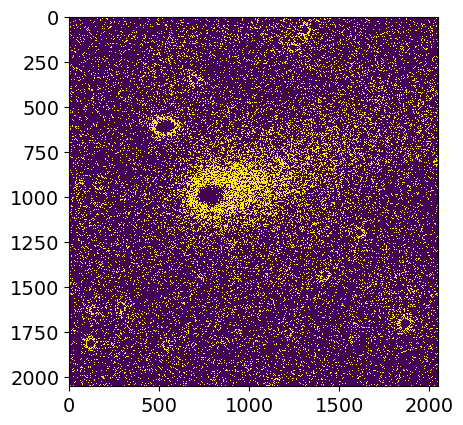

In [8]:
thresholdIndices = np.where(((image - background) > std) & ((image - background) < 3 * std), 1, 0)

plt.imshow(thresholdIndices, interpolation="nearest")